Part 1 of this question is "what is the conceptual difference between nodes and entities?"
Part 2 of this questions "why are entities sometimes repeated twice in the nodes file?"

The output files in question are create_final_entities.parquet and create_final_nodes.parquet (create_final_relationships.parquet is also related).

GraphRAG extracts entities and relationships from text content and generates a graph. This graph is then used as the entry point for algorithms to summarize and answer questions about your dataset. When we extract entities, we create a canonical list of entities including the text units they were found within. This entity data is saved to create_final_entities.parquet.

We then combine the entities table and the relationships table to create a graph (network). Once we put each entity into the graph, it becomes a node in that graph (and the relationships are edges), and thus adopts new semantic meaning and analytic properties. You'll notice, for example, that in the nodes table each entity has a degree, x, y, and size. Degree is the node degree (connectedness), and x and y can be populated with a position in 2D coordinate space for visualizing the graph (see the configs for Node2Vec embeddings and UMAP). We use the degree to represent the size by default, so those columns are equivalent (but you could use any measure you deem important to set the size of a node in a graph visualization...).

As for the duplication: one of the graph analysis steps we run is hierarchical community detection with Leiden. A community will be assigned for every node, at every level in the hierarchy (unless that node becomes too distinct and becomes "orphaned" at some depth). This results in a duplicate entry in the nodes table for each computed community level. So the create_final_nodes.parquet is a one-to-many from create_final_entities.parquet, using the id field as join key.

To summarize: entities are canonical, nodes are a representation of that entity in graph space, and duplication is because we compute hierarchical communities and add an entry for each in the nodes table.

In [500]:
import pandas as pd
import networkx as nx
from utils import  completion
import matplotlib.pyplot as plt

import nltk


In [501]:
output_path = "/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/elec_graph/output_eval/"
#final_node = pd.read_parquet(output_path+'create_final_nodes.parquet')
#final_node.sort_values('degree',ascending=False).head()

In [502]:
final_entities = pd.read_parquet(output_path + 'create_final_entities.parquet')
final_relationships = pd.read_parquet(output_path+'create_final_relationships.parquet')
cleaned_relationships = final_relationships.drop_duplicates(['source','target']).reset_index().drop('index',axis=1)

cleaned_relationships.head()



,source,target,weight,description,text_unit_ids,id,human_readable_id,source_degree,target_degree,rank
0,PRINTED CIRCUIT BOARD,ELECTRONICS ASSEMBLIES,8.0,Printed circuit boards are used in electronics...,[a44b2acb33ebdc552fe7b898386a5329],2c76505cef1446c8869ec84a0f9e7aa9,0,55,1,56
1,PRINTED CIRCUIT BOARD,SOLDERING PROCESSES,8.0,Soldering processes are critical to the constr...,[a44b2acb33ebdc552fe7b898386a5329],10f4ffed47f1463da48c3cca09366f6e,1,55,1,56
2,PRINTED CIRCUIT BOARD,THERMAL CHARACTERISTICS,8.0,Different printed circuit board types have dif...,[a44b2acb33ebdc552fe7b898386a5329],e619e8096d944f749ac6672dedddc796,2,55,1,56
3,PRINTED CIRCUIT BOARD,PRINTED WIRING BOARD,1.0,A printed wiring board is another name for a p...,[a44b2acb33ebdc552fe7b898386a5329],c1930f23f6af476b8044346f51a42f58,3,55,1,56
4,PRINTED CIRCUIT BOARD,BASE,8.0,The base of a printed circuit board is a thin ...,[a44b2acb33ebdc552fe7b898386a5329],64df3d6fcfba43ebba7047cb12d0498a,4,55,4,59


In [503]:
pd.read_parquet('/home/cip/ce/ix05ogym/Majid/LLM/graphrag/graphrag/entity_seed.parquet')

,entity,count
0,printed,14
1,circuit,11
2,board,14
3,one,5
4,form,3
5,components,3
6,boards,3
7,soldering,2
8,processes,2
9,different,2


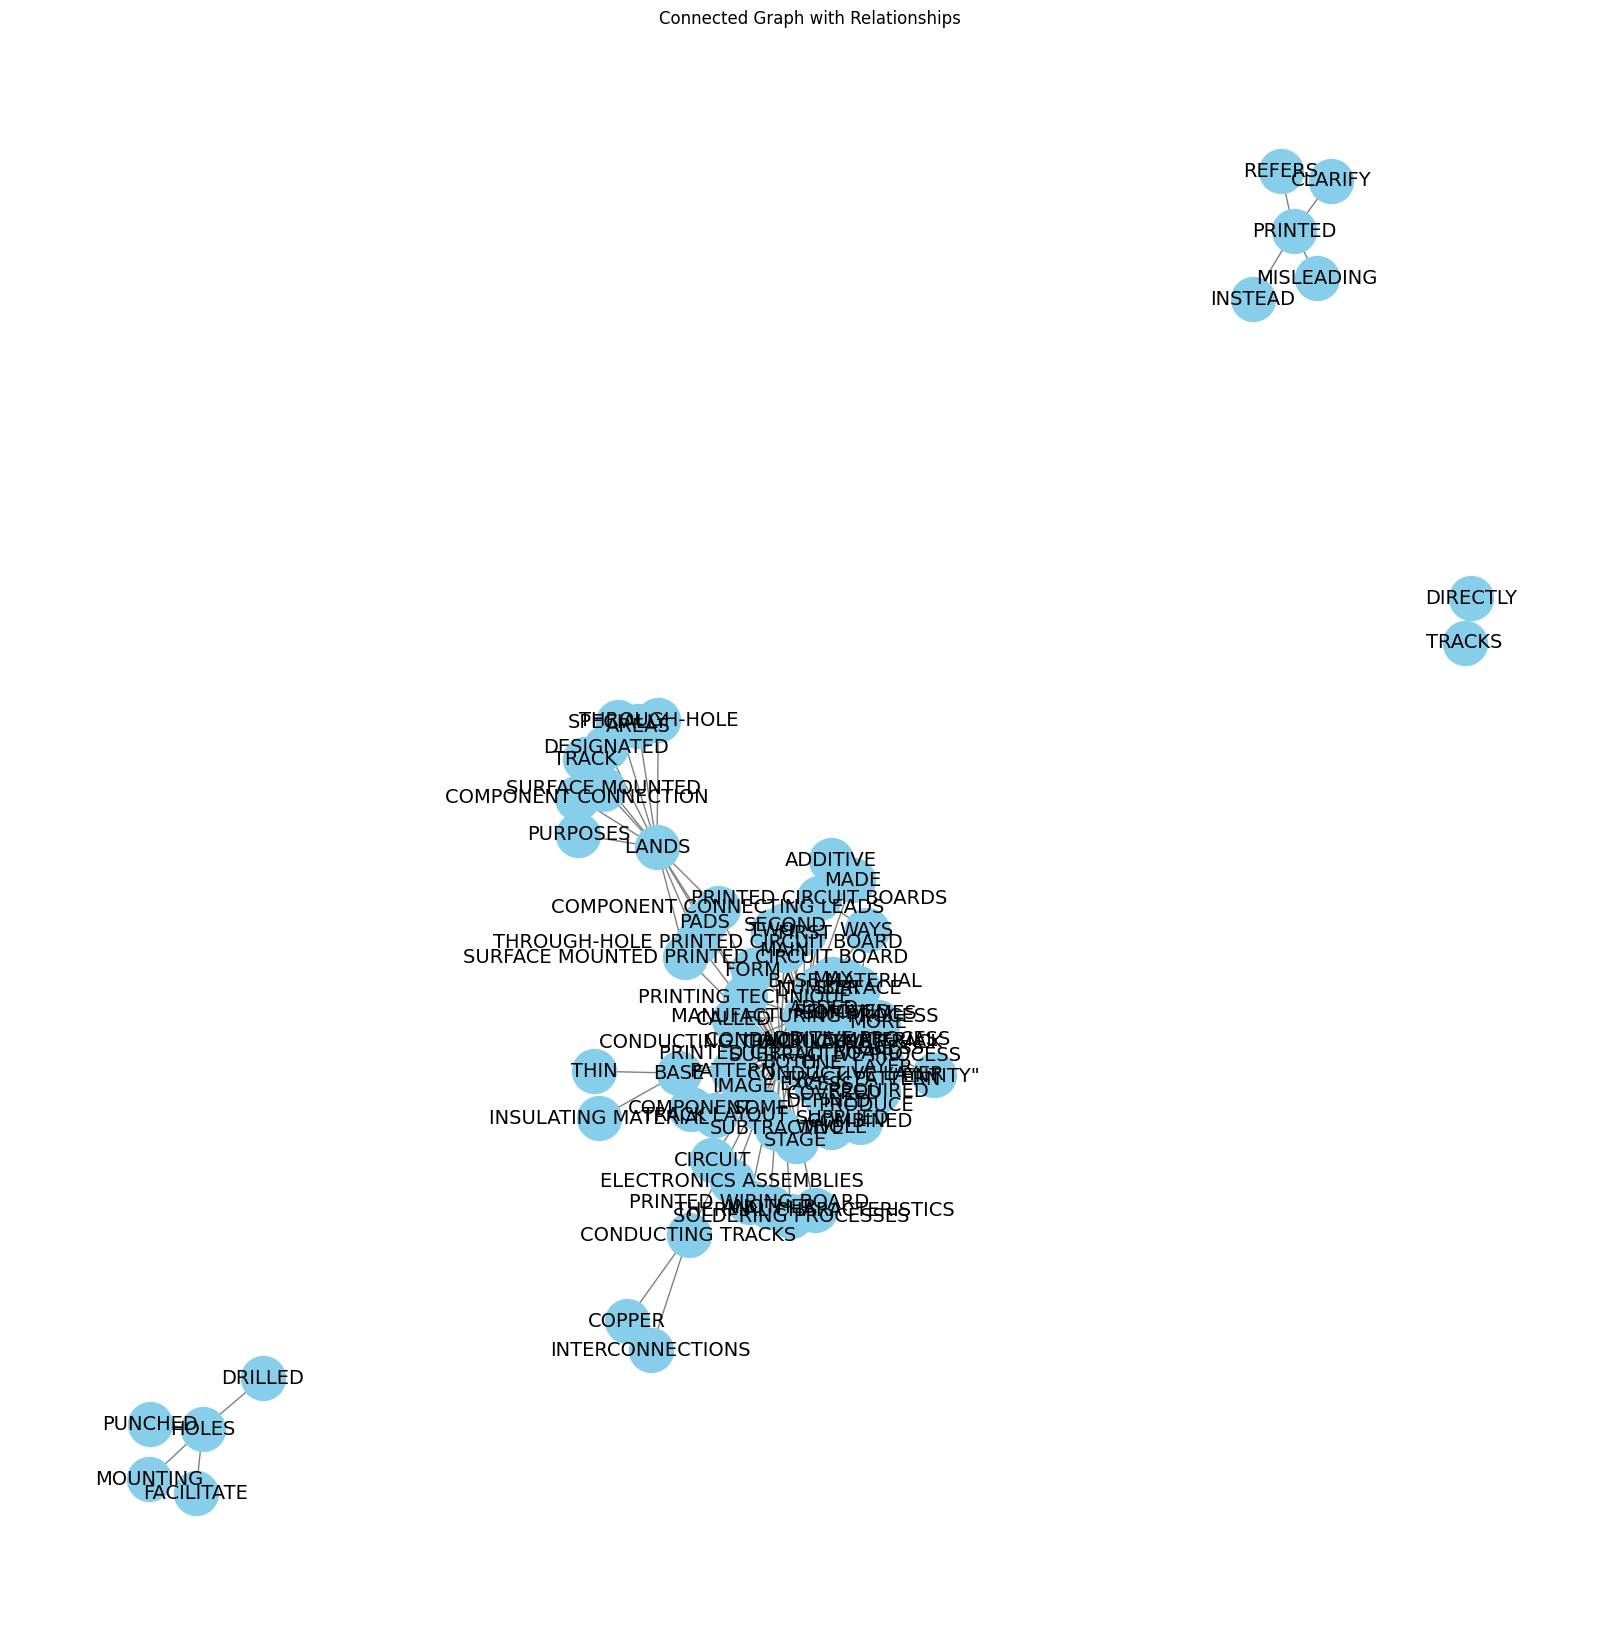

In [504]:


G = nx.from_pandas_edgelist(cleaned_relationships, 'source', 'target')#,edge_attr='relationships')#, create_using=nx.DiGraph())


# Draw the graph
plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G )  # Positioning layout for a visually appealing graph
nx.draw(G,pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color='gray', font_size=14,arrows=True)
#edge_labels = nx.get_edge_attributes(G)#, 'relationships')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=14)

plt.title("Connected Graph with Relationships")
plt.show()


In [505]:
def get_entity_info(final_entities:pd.DataFrame,final_relationships:pd.DataFrame):
    """
    source,target,source_degree,target_degree,rank,type
    
    """

    types = final_entities['type'].value_counts()
    info = {}
    info['number of entities']= len(final_entities)
    info['number of classes']= len(types)
    info['classes'] = types
    cleaned_relationships = final_relationships.drop_duplicates(['source','target']).reset_index().drop('index',axis=1)
    info['number of relationships']= len(cleaned_relationships)
    info['number of relationships outliner']= len(cleaned_relationships[cleaned_relationships['rank']<3])
    info['max source_degree']= cleaned_relationships['source_degree'].max() 
    info['max target_degree']= cleaned_relationships['target_degree'].max()
    info['max rank']= cleaned_relationships['rank'].max()
    info['min rank']= cleaned_relationships['rank'].min()
    info['source_degree/number of relationships']= cleaned_relationships['source_degree'].sum()/len(cleaned_relationships)
    info['target_degree/number of relationships']= cleaned_relationships['target_degree'].sum()/len(cleaned_relationships)
    
    return info

get_entity_info(final_entities,final_relationships)




{'number of entities': 87,
 'number of classes': 10,
 'classes': type
 PROCESS         23
 PROPERTY        13
 COMPONENT       12
 NUMBER          11
 DEVICE           7
 FREQUENCY        6
 RELATIONSHIP     5
 DESIGN           5
 MATERIAL         3
 FUNCTION         1
 Name: count, dtype: int64,
 'number of relationships': 217,
 'number of relationships outliner': 1,
 'max source_degree': 55,
 'max target_degree': 35,
 'max rank': 90,
 'min rank': 2,
 'source_degree/number of relationships': 25.129032258064516,
 'target_degree/number of relationships': 10.345622119815669}

In [506]:
final_relationships.sort_values('weight',ascending=False).head()


,source,target,weight,description,text_unit_ids,id,human_readable_id,source_degree,target_degree,rank
650,COMPONENT CONNECTING LEADS,LANDS,56.0,Component connecting leads are electrically co...,[a44b2acb33ebdc552fe7b898386a5329],d2b848d761cf476898c160c8074f04bb,60,2,13,15
212,PRINTED CIRCUIT BOARD,ONE,56.0,A printed circuit board (PCB) is a single inst...,[a44b2acb33ebdc552fe7b898386a5329],2901325b4d5f460bbc142c56b6610240,17,55,6,61
225,PRINTED CIRCUIT BOARD,ONE,56.0,A printed circuit board (PCB) is a single inst...,[a44b2acb33ebdc552fe7b898386a5329],2901325b4d5f460bbc142c56b6610240,17,55,6,61
651,COMPONENT CONNECTING LEADS,LANDS,56.0,Component connecting leads are electrically co...,[a44b2acb33ebdc552fe7b898386a5329],d2b848d761cf476898c160c8074f04bb,60,2,13,15
224,PRINTED CIRCUIT BOARD,ONE,56.0,A printed circuit board (PCB) is a single inst...,[a44b2acb33ebdc552fe7b898386a5329],2901325b4d5f460bbc142c56b6610240,17,55,6,61


In [507]:
be = pd.read_parquet(output_path+'create_base_entity_graph.parquet')
be

,level,clustered_graph,embeddings
0,0,"<graphml xmlns=""http://graphml.graphdrawing.or...","{'(""ENTITY""': [-0.012449857778847218, -0.01449..."
1,1,"<graphml xmlns=""http://graphml.graphdrawing.or...","{'(""ENTITY""': [-0.012864199467003345, -0.01358..."


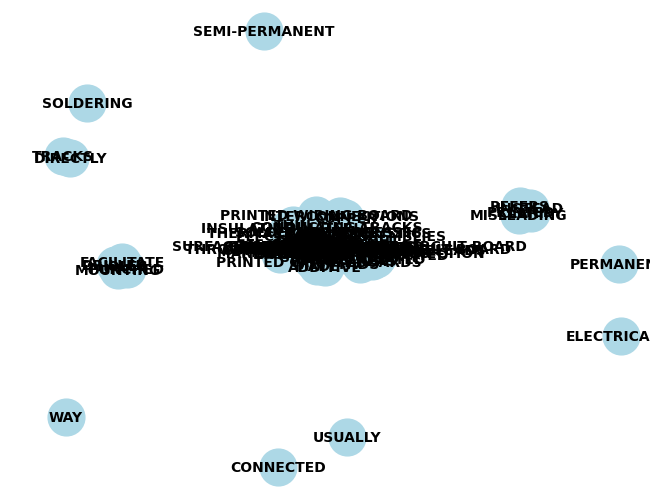

In [508]:
g = nx.read_graphml(output_path+'summarized_graph.graphml')
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')

g

In [509]:
def eval_entity(relationships):
    example = """
    {
    'source': IMAGE
    'target': MANUFACTURING PROCESS
    'description': The image of the conductive track layout is created during the manufacturing process.
    },
    {
    'source': 'EXCESS CONDUCTIVE MATERIAL',
    'target': 'SUBTRACTIVE PROCESS',
    'description': 'The subtractive process involves removing excess conductive material'
    },
    {
    'source': 'THERMAL CHARACTERISTICS',
    'target': 'COMPONENT',
    'description': 'The thermal characteristics of the printed circuit board can affect the components'
    }

    Output:
    [
        {
            "reason": "Both 'IMAGE' and 'PATTERN' are vague terms in this context, lacking specificity. They should be more domain-specific, such as 'Track Image' or 'Conductive Pattern' for clarity. Additionally, the relationship 'is the same as' is misleading and unclear, as an image represents the pattern but is not literally the same.",
            "source": "IMAGE",
            "source_rate": 1,
            "target": "PATTERN",
            "target_rate": 2,
            "description_rate": 1
        },
        {
            "reason": "'THERMAL CHARACTERISTICS' and 'COMPONENT' lack clarity in their connection. While relevant, the terms are too broad, and the relationship is vague without specifying how thermal characteristics affect components, making it unclear.",
            "source": "THERMAL CHARACTERISTICS",
            "source_rate": 2,
            "target": "COMPONENT",
            "target_rate": 1,
            "description_rate": 1
        },
        {
            "reason": "'EXCESS CONDUCTIVE MATERIAL' and 'SUBTRACTIVE PROCESS' are precise and domain-specific, directly relevant to the process of printed circuit board manufacturing.",
            "source": "EXCESS CONDUCTIVE MATERIAL",
            "source_rate": 3,
            "target": "SUBTRACTIVE PROCESS",
            "target_rate": 3,
            "description_rate": 3
        },

    ]
    """

    prompt="""As part of our evaluation of Knowledge Graph models, we ask you to rate a selection of extracted entity-relation triplets to help assess entity and relation quality. Please use the following guidelines to rate each triplet on a scale from 1 to 3, where 1 is "poor" and 3 is "excellent." Your feedback will help us determine model performance and refine KGC methods.
    Guidelines
    Entity Quality
    Excellent (3 points): Entities are highly relevant and specific to the domain, representing an ideal level of detail—not too broad or overly specific. The entity could reasonably be the subject of a lecture, slide, or even a Wikipedia page.
    Acceptable (2 points): Entity relevance and detail are generally suitable, though it may lack some specificity.
    Poor (1 point): Entity is too broad or overly specific, making it inappropriate for the context.
    Relation Quality
    Correct (3 points): The relation between the head and tail entities is logically accurate and contextually appropriate.
    Somewhat Correct (2 points): Relation has minor inaccuracies or could be improved with a more precise term.
    Incorrect (1 point): The relation is illogical or irrelevant given the two entities.
    Please provide output in the following JSON format:
    {{
        "reason": string the reason behinde the rate of source,target,description,
        "source": string,
        "source_rate": number,
        "target": string,
        "target_rate": number,
        "description_rate": number
    }}
    # Example #
    {example}
    # End of Example

    # Real Data #
    {data}
    # End of Real Data
    Do not give the same reason twice.
    Output:
    """.format(data=res['relationships'],example=example)

    print(prompt)

    eval_results = completion(prompt,temperature=0.0)
    return pd.DataFrame.from_dict(eval_results)


In [510]:
df = eval_entity(res['relationships'])
df.boxplot(column=['source_rate','target_rate','description_rate'])
df.plot(kind='bar')
df.mean(axis=0,numeric_only=True)
#df.median(axis=0,numeric_only=True)

NameError: name 'res' is not defined

In [ ]:

#graph = nx.read_graphml(output_path+'clustered_graph.0.graphml')

def get_subgraph_with_descendants(graph, node):
    # Get all descendants of the node (DFS)
    #descendants = list(nx.descendants(graph, node))  # Returns all descendants of the node
    #descendants = list(nx.bfs_successors(graph,'QUALITY',1))
    
    #descendants = descendants[0][1]
    descendants = list(nx.ego_graph(graph,node,1))
    # Include the original node
    descendants.append(node)
    
    # Create the subgraph from the descendants
    subgraph = graph.subgraph(descendants)
    
    return subgraph

subgraph = get_subgraph_with_descendants(g, 'QUALITY')

pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')


In [ ]:
descendants = list(nx.bfs_successors(graph,'QUALITY',1))
descendants[0][1]

In [ ]:
path = nx.shortest_path(graph, source='ADDRESSES', target='ALLOY',)
for i in range(len(path) - 1):
    u = path[i]
    v = path[i + 1]
    description = graph[u][v]['description']
    print(f"{u} -> {v}: {description}")

In [ ]:
data = pd.read_csv('/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/elec_graph/input/soldering.csv')
docs = data['text'].tolist()

In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
def get_seed_entity(texts:list[str]):

    # Download the necessary resources from NLTK
    nltk.download('stopwords')
    nltk.download('punkt')

    # Example list of texts (you can replace this with your own list of texts)
    texts = docs
    # Tokenize, clean, and count words in all texts
    stop_words = set(stopwords.words('english'))

    # Initialize an empty Counter to accumulate word counts
    total_word_counts = Counter()

    # Loop over each text in the list
    for text in texts:
        # Tokenize the text into words
        words = nltk.word_tokenize(text.lower())  # Convert to lower case for uniformity

        # Filter out stopwords and non-alphabetic words
        filtered_words = [word for word in words if word.isalpha() and word not in stop_words]

        # Update the total word counts
        total_word_counts.update(filtered_words)

    # Filter words that appear at least twice
    filtered_word_counts = {word: count for word, count in total_word_counts.items() if count >= 2}

    print(filtered_word_counts)
    
    return filtered_word_counts


In [ ]:
example = \
{
    'soldering': 207, 'electronics': 44, 'assembly': 49, 'circuit': 67, 'board': 80,
    'processes': 76, 'components': 55, 'surface': 52, 'solder': 125, 'joint': 30,
    'quality': 21, 'safety': 11, 'soldered': 35, 'solderability': 15, 'flux': 19,
    'cleaning': 20, 'adhesive': 5, 'temperature': 8, 'inspection': 5, 'standards': 8,
    'manufacture': 8, 'machines': 5, 'process': 54, 'metallurgical': 3, 'properties': 5,
    'classification': 6, 'jointing': 2, 'alloys': 5, 'handling': 6, 'resin': 9, 'wiring': 3,
    'conductive': 6, 'reinforced': 6, 'layer': 11, 'laminates': 2, 'epoxide': 5, 'polyimide': 4,
    'inspection': 5, 'inspection': 5, 'wave': 13, 'wetting': 14, 'testing': 2, 'welding': 4,
    'conductor': 9, 'oxide': 3, 'tarnish': 3, 'oxidize': 3, 'melting': 3, 'metallic': 7,
    'conductive': 6, 'plated': 9, 'laminate': 5, 'iron': 3, 'heat': 10, 'holes': 9,
    'vias': 9, 'materials': 13, 'copper': 29, 'glass': 13, 'adhesive': 5, 'adhesive': 5,
    'mounting': 2, 'conductors': 2, 'bond': 9, 'application': 15, 'resin': 9, 'conductive': 6
}

example_entity =\
    {
    'soldering': 207,
    'electronics': 44,
    'assembly': 49,
    'mike': 2,
    'judd': 2,
    'keith': 2,
    'brindley': 2,
    'newnes': 3,
    'reed': 2,
    'group': 2,
    'first': 10,
    'part': 6,
    'publication': 4,
    'material': 16,
    'electronic': 7,
    'design': 3,
    'applications': 4,
    'british': 3,
    'library': 2,
    'book': 14,
    'printing': 2,
    'printed': 66,
    'produced': 2,
    'care': 2,
    'foreword': 3,
    'preface': 6,
    'acknowledgements': 4,
    'process': 54,
    'time': 10,
    'circuit': 67,
    'board': 80,
    'processes': 76,
    'cs': 16,
    'sc': 22,
    'cleaning': 20,
    'quality': 21,
    'safety': 11,
    'assemblies': 32,
    'joints': 35,
    'surface': 52,
    'mounted': 24,
    'components': 55,
    'solder': 125,
    'joint': 30,
    'solderability': 15,
    'protective': 6,
    'coatings': 5,
    'flux': 19,
    'work': 3,
    'fluxes': 8,
    'application': 15,
    'paste': 13,
    'adhesive': 5,
    'dispensing': 2,
    'hand': 23,
    'pumps': 3,
    'heaters': 2,
    'monitoring': 2,
    'heat': 10,
    'vapour': 2,
    'temperature': 8,
    'clean': 9,
    'contamination': 2,
    'testing': 2,
    'problems': 13,
    'inspection': 5,
    'standards': 8,
    'guide': 3,
    'defects': 3,
    'manufacture': 8,
    'production': 9,
    'equipment': 12,
    'technologies': 3,
    'requirements': 4,
    'growth': 3,
    'operations': 3,
    'important': 12,
    'machine': 14,
    'machines': 5,
    'alpha': 5,
    'metals': 18,
    'cookson': 2,
    'years': 9,
    'materials': 13,
    'techniques': 10,
    'technology': 15,
    'global': 4,
    'industry': 9,
    'products': 8,
    'cost': 10,
    'parts': 12,
    'figure': 26,
    'copper': 29,
    'interconnections': 2,
    'layers': 12,
    'vias': 9,
    'conductive': 6,
    'added': 3,
    'resin': 9,
    'epoxide': 5,
    'flexible': 6,
    'polyimide': 4,
    'bonding': 2,
    'filaments': 3,
    'polyethylene': 3,
    'terephthalate': 3,
    'silicone': 2,
    'melt': 2,
    'temperatures': 3,
    'wave': 13,
    'intermetallic': 7,
    'compounds': 5,
    'testing': 2,
    'welding': 4,
    'wetting': 14,
    'wet': 3
}

def clean_seed_entity(filtered_word_counts):
    prompt=\
    """You are given a list of possible entities with their frequencies.
    Your task is to filter out those that are too general or not meaningful i.e. not suitable for being an entity.
    Filter out those that do not seem relevant to others. Also, keep only one of duplicate or very similar entities.
    Your output format should be the same.
    Possible entities:
    {filtered_word_counts}
    Filtered entities:
    """.format(filtered_word_counts=filtered_word_counts)
    print(prompt)
    return completion(prompt,"",False,temperature=0.7)